# CSF-MRI demo – quick data sanity check

In [5]:
import sys
import pathlib
sys.path.append(str(pathlib.Path().resolve().parent))
import random, numpy as np, matplotlib.pyplot as plt, yaml, torch

from src.datasets.csf_volume_dataset import CSFVolumeDataset, _center_crop

Subject: Patient_2202021349
phase (32, 240, 240) mag (32, 240, 240) manual_mask (240, 240)


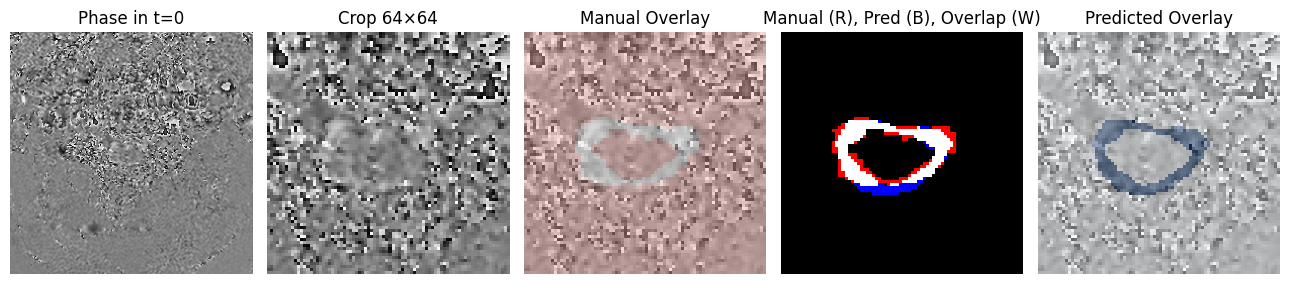

In [19]:
# Load config
cfg = yaml.safe_load(open('../config.yaml'))
data_root = pathlib.Path('../') / cfg['data']['root'] / cfg['data']['test_dir']
SUBJECT = None

random_participant = False
if random_participant:
    subj_dir = random.choice([p for p in data_root.iterdir() if p.is_dir()])
else:
    # Select specific subject
    SUBJECT = 'Patient_2202021349'
    subj_dir = data_root / SUBJECT
print('Subject:', subj_dir.name)

phase = np.load(subj_dir / 'phase.npy')   # (32,240,240)
mag   = np.load(subj_dir / 'mag.npy')     # (32,240,240)
manual_mask  = np.load(subj_dir / 'mask.npy')    # (240,240)

# Confirm shapes
print('phase', phase.shape, 'mag', mag.shape, 'manual_mask', manual_mask.shape)

# Centre-crop to 64×64 and visualise one magnitude slice with overlay
crop = cfg['data']['crop_size']

mag0  = _center_crop(mag[0],  crop) / mag.max()  # normalise for display
phase0 = _center_crop(phase[0], crop) / phase.max()  # normalise for display
manual_mask_c= _center_crop(manual_mask,     crop)
pred_mask_c = np.load(f"../outputs/preds/{SUBJECT}_pred.npy")  # (80,80) according to config
pred_mask_c_bin = (pred_mask_c > 0.5).astype(np.uint8)

# Ensure pred_mask_c_bin is cropped to the same size as mag0/manual_mask_c
if pred_mask_c_bin.shape != mag0.shape:
    pred_mask_c_bin = _center_crop(pred_mask_c_bin, crop)

plt.figure(figsize=(13,3))

plt.subplot(1,5,1)
plt.imshow(phase[0], cmap='gray')
plt.title('Phase in t=0')
plt.axis('off')

plt.subplot(1,5,2)
plt.imshow(phase0, cmap='gray')
plt.title('Crop 64×64')
plt.axis('off')

plt.subplot(1,5,3)
plt.imshow(phase0, cmap='gray')
plt.imshow(manual_mask_c, cmap='Pastel1', alpha=0.4)  # yellow overlay
plt.title('Manual Overlay')
plt.axis('off')

plt.subplot(1,5,4)
# Overlay manual (yellow) and predicted (blue) masks, no background
overlay = np.zeros((*mag0.shape, 3))
overlay[..., 0] = np.where(manual_mask_c > 0, 1, 0)  # Red channel for manual
overlay[..., 2] = np.where(pred_mask_c_bin > 0, 1, 0)    # Blue channel for predicted
overlay[..., 1] = np.where((manual_mask_c > 0) & (pred_mask_c_bin > 0), 1, 0)  # Green for overlap
plt.imshow(overlay, alpha=1.0)  # No background
plt.title('Manual (R), Pred (B), Overlap (W)')
plt.axis('off')

plt.subplot(1,5,5)
plt.imshow(phase0, cmap='gray')
plt.imshow(pred_mask_c_bin, cmap='Blues', alpha=0.4)
plt.title('Predicted Overlay')
plt.axis('off')

plt.tight_layout()